# Feature data only

In [216]:
import pandas as pd
import numpy as np
import math
import os
import seaborn as sb

## Read in the data

In [217]:
player = pd.read_csv('https://raw.githubusercontent.com/jchristo12/fantasy_football/master/data/predictor/player_offense.csv')

In [218]:
#rename columns
player.rename(columns={'seas.1': 'exp'}, inplace=True)

In [219]:
player.columns

Index(['pk', 'gid', 'seas', 'wk', 'player', 'fname', 'lname', 'full_name',
       'team', 'pos1', 'nflid', 'pa', 'pc', 'py', 'ints', 'tdp', 'ra', 'sra',
       'ry', 'tdr', 'fuml', 'trg', 'rec', 'recy', 'tdrec', 'ret', 'rety',
       'tdret', 'exp', 'height', 'weight', 'dob', 'dv', 'forty', 'bench',
       'vertical', 'broad', 'shuttle', 'cone', 'arm', 'hand'],
      dtype='object')

In [220]:
#convert column types to appropriate data types
player = player.astype({'seas': 'category',
          'wk': 'category',
          'team': 'category',
          'pos1': 'category',
          'dv': 'category',
          'exp': 'category'})

## Lagged & Cumulative Stats

Need to lag the information by one week to see if we can predict the next week's fantasy points.<br>
The game information can stay at the current week as long as we can know it before the week starts.

In [221]:
#sort the stats
player_sorted = player.sort_values(by=['player', 'gid'], ascending=True)

In [222]:
#unique player list
unique_players = player_sorted['player'].unique()

#### Last game stats

Simply need to lag the normal stats by one week.

In [223]:
#lag by one week for each player, contained by each season
last_stats = player_sorted.groupby(by=['player', 'seas']).shift(1).loc[:, 'pa':'tdret'].add_prefix('last_')

#### Career stats

In [224]:
#group, lag, and calculate the cumulative sum of all of the stats
career_stats = pd.concat([player_sorted['player'], player_sorted.groupby(by='player', group_keys=True).shift(1).loc[:, 'pa':'tdret']], axis=1).groupby('player').cumsum().loc[:, 'pa':'tdret'].add_prefix('career_')

#### 4-game rolling

4-game rolling sum for each season for each player<br>
Lagged by 1 week

In [225]:
recent_stats = pd.concat([player_sorted.loc[:, ['player', 'seas']], player_sorted.groupby(by=['player', 'seas'])\
               .shift(1).loc[:, 'pa':'tdret']], axis=1).groupby(by=['player', 'seas'], as_index=True)\
               .rolling(window=4, min_periods=1).sum().add_prefix('recent_').reset_index(drop=True)

#### Season stats

Calculate the rolling seasonal stats

In [226]:
#store columns to identify the columns (these will be used for grouping a second time)
identifiers = player_sorted.loc[:, ['pk', 'player', 'seas', 'wk']]

In [227]:
#group by player and season so that when the shift is applied, we lag by 1 week for each player each season
seas_grouped_shift = player_sorted.groupby(by=['player', 'seas'], as_index=True).shift(1).loc[:, 'pa':'tdret']

In [228]:
#add the identifying features to the shifted dataframe
#store as an interim dataframe because NaN's will need to be removed
seas_interim = pd.concat([identifiers, seas_grouped_shift], axis=1)

In [229]:
#remove the NaN rows (the lagged rows)
seas_clean = seas_interim[seas_interim.notna().all(axis=1)]

In [230]:
#group and calculate the season totals
seas_stats_no_pk = seas_clean.groupby(by=['player', 'seas']).cumsum().add_prefix('seas_')

In [231]:
#add identifying feature so the merge to the full dataframe will work
seas_stats = pd.concat([seas_clean['pk'], seas_stats_no_pk], axis=1)

In [232]:
#add the season rolling stats to the full dataframe
player_sorted_seas = player_sorted.merge(seas_stats, on='pk', how='left')

##### Add all of the data together

In [233]:
player_rolling_sort = pd.concat([player_sorted_seas, last_stats, career_stats, recent_stats], axis=1)
player_rolling_sort.shape

(94759, 109)

## Add other features

In [234]:
for i in player_rolling_sort.columns: print(i)

pk
gid
seas
wk
player
fname
lname
full_name
team
pos1
nflid
pa
pc
py
ints
tdp
ra
sra
ry
tdr
fuml
trg
rec
recy
tdrec
ret
rety
tdret
exp
height
weight
dob
dv
forty
bench
vertical
broad
shuttle
cone
arm
hand
seas_pa
seas_pc
seas_py
seas_ints
seas_tdp
seas_ra
seas_sra
seas_ry
seas_tdr
seas_fuml
seas_trg
seas_rec
seas_recy
seas_tdrec
seas_ret
seas_rety
seas_tdret
last_pa
last_pc
last_py
last_ints
last_tdp
last_ra
last_sra
last_ry
last_tdr
last_fuml
last_trg
last_rec
last_recy
last_tdrec
last_ret
last_rety
last_tdret
career_pa
career_pc
career_py
career_ints
career_tdp
career_ra
career_sra
career_ry
career_tdr
career_fuml
career_trg
career_rec
career_recy
career_tdrec
career_ret
career_rety
career_tdret
recent_fuml
recent_ints
recent_pa
recent_pc
recent_py
recent_ra
recent_rec
recent_recy
recent_ret
recent_rety
recent_ry
recent_sra
recent_tdp
recent_tdr
recent_tdrec
recent_tdret
recent_trg


##### Function to calculate various ratio stats for all cumulative versions (i.e. career, season, 4-game, etc.)

In [235]:
def ratio_stat(num_col, denom_col, new_col, data=player_rolling_sort):
    #last game stat calc
    last_col = data['last_' + num_col] / data['last_' + denom_col]
    #career stat calc
    career_col = data['career_' + num_col] / data['career_' + denom_col]
    #season stat calc
    seas_col = data['seas_' + num_col] / data['seas_' + denom_col]
    #rolling game stat calc
    rolling_col = data['recent_' + num_col] / data['recent_' + denom_col]
    
    #concate the series together
    added_df = pd.concat([data, career_col, seas_col, rolling_col, last_col], axis=1)
    added_df.rename(columns={0: 'career_'+new_col,
                             1: 'seas_'+new_col,
                             2: 'roll_'+new_col,
                             3: 'last_'+new_col}, inplace=True)
    
    return added_df

### Passing summaries

In [236]:
#Passing completion
player_rolling_sort = ratio_stat('pc', 'pa', 'comp_pct', data=player_rolling_sort)

In [237]:
#touchdown to interception ratio
player_rolling_sort = ratio_stat('tdp', 'ints', 'td_to_int', data=player_rolling_sort)

In [238]:
#Passing yards per completion
player_rolling_sort = ratio_stat('py', 'pc', 'yds_per_comp', data=player_rolling_sort)

### Running summaries

In [239]:
#Yards per rush
player_rolling_sort = ratio_stat('ry', 'ra', 'ryds_per_carry', data=player_rolling_sort)

In [240]:
#Carries to touchdown ratio
player_rolling_sort = ratio_stat('ra', 'tdr', 'carry_to_td', data=player_rolling_sort)

In [241]:
#Carries to fumbles lost ratio
player_rolling_sort = ratio_stat('ra', 'fuml', 'carry_to_fuml', data=player_rolling_sort)

### Receiving stats

In [242]:
#catch percent (catches/targets)
player_rolling_sort = ratio_stat('rec', 'trg', 'catch_pct', data=player_rolling_sort)

In [243]:
#yards per catch
player_rolling_sort = ratio_stat('recy', 'rec', 'yds_per_rec', data=player_rolling_sort)

In [244]:
#rec to td's
player_rolling_sort = ratio_stat('rec', 'tdrec', 'rec_to_td', data=player_rolling_sort)

### Return stats

In [245]:
#average return yards
player_rolling_sort = ratio_stat('rety', 'ret', 'avg_ret', data=player_rolling_sort)

In [246]:
#returns to td's
player_rolling_sort = ratio_stat('ret', 'tdret', 'ret_to_td', data=player_rolling_sort)

### Age

In [247]:
#strip out the year from DOB
dob_year = player_rolling_sort['dob'].apply(lambda x: int(str(x[-4:])))

In [248]:
#add age to dataframe
player_rolling_sort['age'] = player_rolling_sort['seas'].astype(int) - dob_year

In [249]:
#check
player_rolling_sort['age'].head()

0    22
1    22
2    22
3    22
4    22
Name: age, dtype: int64

### Final checks

In [250]:
for i in player_rolling_sort.columns: print(i)

pk
gid
seas
wk
player
fname
lname
full_name
team
pos1
nflid
pa
pc
py
ints
tdp
ra
sra
ry
tdr
fuml
trg
rec
recy
tdrec
ret
rety
tdret
exp
height
weight
dob
dv
forty
bench
vertical
broad
shuttle
cone
arm
hand
seas_pa
seas_pc
seas_py
seas_ints
seas_tdp
seas_ra
seas_sra
seas_ry
seas_tdr
seas_fuml
seas_trg
seas_rec
seas_recy
seas_tdrec
seas_ret
seas_rety
seas_tdret
last_pa
last_pc
last_py
last_ints
last_tdp
last_ra
last_sra
last_ry
last_tdr
last_fuml
last_trg
last_rec
last_recy
last_tdrec
last_ret
last_rety
last_tdret
career_pa
career_pc
career_py
career_ints
career_tdp
career_ra
career_sra
career_ry
career_tdr
career_fuml
career_trg
career_rec
career_recy
career_tdrec
career_ret
career_rety
career_tdret
recent_fuml
recent_ints
recent_pa
recent_pc
recent_py
recent_ra
recent_rec
recent_recy
recent_ret
recent_rety
recent_ry
recent_sra
recent_tdp
recent_tdr
recent_tdrec
recent_tdret
recent_trg
career_comp_pct
seas_comp_pct
roll_comp_pct
last_comp_pct
career_td_to_int
seas_td_to_int
roll_td_to_in

## Game features

### Read in data

In [251]:
game = pd.read_csv('https://raw.githubusercontent.com/jchristo12/fantasy_football/master/data/predictor/game.csv')

In [252]:
#change the data types to the correct format
game = game.astype({'v': 'category',
                   'h': 'category',
                   'day': 'category',
                   'cond': 'category',
                   'stad': 'category',
                   'wdir': 'category',
                   'surf': 'category'})

In [253]:
game.head()

,gid,v,h,day,cond,stad,temp,wdir,surf,humd,ou,sprv,ptsv,ptsh
0,1,SF,ATL,SUN,Dome,Georgia Dome,79.0,NaN,AstroTurf,NaN,42.5,7.0,28,36
1,2,JAC,CLE,SUN,Sunny,Cleveland Browns Stadium,78.0,NE,Grass,63.0,38.0,-10.0,27,7
2,3,PHI,DAL,SUN,Sunny,Texas Stadium,109.0,S,AstroTurf,19.0,40.0,6.0,41,14
3,4,NYJ,GB,SUN,Mostly Cloudy,Lambeau Field,77.0,E,Grass,66.0,36.0,2.5,20,16
4,5,IND,KC,SUN,Mostly Sunny,Arrowhead Stadium,90.0,E,Grass,50.0,44.0,-3.0,27,14


### Feature creation

#### Underdog feature

In [254]:
#add underdog category
game['udog'] = pd.Series(np.where(game['sprv'] > 0, game['v'], game['h']), dtype='category')

In [255]:
game.head(2)

,gid,v,h,day,cond,stad,temp,wdir,surf,humd,ou,sprv,ptsv,ptsh,udog
0,1,SF,ATL,SUN,Dome,Georgia Dome,79.0,NaN,AstroTurf,NaN,42.5,7.0,28,36,SF
1,2,JAC,CLE,SUN,Sunny,Cleveland Browns Stadium,78.0,NE,Grass,63.0,38.0,-10.0,27,7,CLE


#### Remap condition categories

There are too many categories and too many that are similar. Want to map the categories to a smaller number for analysis.

In [256]:
#dictionary of general conditions
general_cond = {'indoor_cond': ['Closed Roof', 'Covered Roof', 'Dome'], 
                'percip_cond': ['Flurries', 'Light Rain', 'Light Showers', 'Light Snow',
                                'Rain', 'Showers', 'Snow', 'Thunderstorms', 'Chance Rain'],
                'fair_cond': ['Clear', 'Sunny', 'Cloudy', 'Cold', 'Fair', 'Foggy', 'Hazy', 'Mostly Cloudy',
                              'Mostly Sunny', 'Overcast', 'Partly Cloudy', 'Partly CLoudy', 'Partly Sunny',
                              'Sunny', 'Windy']}


In [257]:
#map the keys to each value to be used in category creation
general_cond_flipped = {old: new for new, old_all in general_cond.items() for old in old_all}

In [258]:
#create a general conditions feature
game['gen_cond'] = game['cond'].apply(lambda x: general_cond_flipped[x])

#### Making sure humd and wdir makes sense for dome stadiums

In [259]:
#for all indoor cond, set the wdir and humd to what makes sense for indoor playing conditions
game.loc[game['gen_cond']=='indoor_cond', ['wdir', 'humd']] = ['CALM', 45]

45% relative humidity is the average for indoor spaces<br>
https://www.thermastor.com/relative-humidity-and-your-home/

## Combine data

In [260]:
#combine game and offensive player data
player_game = player_rolling_sort.merge(game, how='left', on='gid', suffixes=('_poff', '_game'))

In [261]:
player_game.head()

,pk,gid,seas,wk,player,fname,lname,full_name,team,pos1,...,temp,wdir,surf,humd,ou,sprv,ptsv,ptsh,udog,gen_cond
0,3999&AA-0025,3999,2015,1,AA-0025,Ameer,Abdullah,Ameer Abdullah,DET,RB,...,84.0,WSW,Grass,47.0,46.0,3.0,28,33,DET,fair_cond
1,4010&AA-0025,4010,2015,2,AA-0025,Ameer,Abdullah,Ameer Abdullah,DET,RB,...,67.0,NaN,FieldTurf,NaN,43.5,2.0,16,26,DET,fair_cond
2,4036&AA-0025,4036,2015,3,AA-0025,Ameer,Abdullah,Ameer Abdullah,DET,RB,...,NaN,CALM,FieldTurf,45.0,44.5,-3.0,24,12,DET,indoor_cond
3,4052&AA-0025,4052,2015,4,AA-0025,Ameer,Abdullah,Ameer Abdullah,DET,RB,...,74.0,N,FieldTurf,41.0,43.0,10.0,10,13,DET,fair_cond
4,4062&AA-0025,4062,2015,5,AA-0025,Ameer,Abdullah,Ameer Abdullah,DET,RB,...,NaN,CALM,FieldTurf,45.0,44.5,-3.0,42,17,DET,indoor_cond


### Underdog binary feature

Create a feature that compares the udog team to the team of the player. If equal, then that player is on the underdog team

In [262]:
player_game['udog_binary'] = player_game['team'].eq(player_game['udog'])

### College Conference combination

Because we only care about the Power 5 conferences, we'll drop the categories to 6 groups: the power five and 'other'

In [263]:
#replace Pacific 10 with Pacific 12 (name change)
player_game['dv'].replace('Pacific 10', 'Pacific 12', inplace=True)

In [264]:
power_five = ['Big 12', 'Big Ten', 'Atlantic Coast (ACC)', 'Southeastern (SEC)', 'Pacific 12']

In [265]:
#if conference is in the power 5, then leave it. Otherwise, call it 'Other'
player_game['gen_dv'] = pd.Series(np.where(player_game['dv'].isin(power_five), player_game['dv'], 'Other'), dtype='category')

### Defensive Rankings features

In [266]:
#create a new categorical column of the defensive team
player_game['def_team'] = pd.Series(np.where(player_game['team'] == player_game['h'], player_game['v'],
                                             player_game['h']), dtype='category')

In [267]:
#sum the offensive stats given up by the defense by team, season, and week
team_seas_wk = player_game.groupby(['def_team', 'seas', 'wk'], as_index=True).sum().loc[:, 'pa':'tdret']

Need to do this because the data is broken out by player and we need total team stats<br>
NaN weeks represent each team's bye week

In [268]:
#remove the bye weeks
t_s_w_no_bye = team_seas_wk[team_seas_wk.notna().all(axis=1)]

#### Calculate running totals for each

Need to lag by one week. Will calculate season running total and 4 game running total

In [269]:
#store the identifying features
identifiers = t_s_w_no_bye.reset_index(['def_team', 'seas', 'wk']).loc[:, 'def_team':'wk']

In [270]:
#reset index and then regroup by team and season
#also shift the data by one
t_s_w_grouped_shift = t_s_w_no_bye.reset_index(['def_team', 'seas', 'wk']).groupby(by=['def_team', 'seas']).shift(1)

In [271]:
#concate identifying features to shifted
tsw_full = pd.concat([identifiers, t_s_w_grouped_shift.loc[:, 'pa':'tdret']], axis=1)

In [272]:
#remove the rows that are NaN due to the lagging (week 1 of each season)
tsw_clean = tsw_full[tsw_full.loc[:, 'pa':'tdret'].notna().all(axis=1)]

In [273]:
#store tsw_clean identifiers
tsw_clean_identifiers = tsw_clean.loc[:, 'def_team':'wk']

In [304]:
#calculate the rolling mean
def_mean = tsw_clean.groupby(by=['def_team', 'seas'], sort=False).rolling(window=4, min_periods=1).sum().reset_index().loc[:, 'fuml':'trg']

In [305]:
#combine the identifiers and the def_mean
#reset the indexes of both columns so that they concat nicely
def_mean_clean = pd.concat([tsw_clean_identifiers.reset_index(drop=True), def_mean.reset_index(drop=True)], axis=1)

<br>The below code will calculate the ranks for each of the columns<br>
Have to separate out stats that should be ranked ascending (more is worse) and decending (more is better)

In [306]:
def_mean_clean.head()

,def_team,seas,wk,fuml,ints,pa,pc,py,ra,rec,recy,ret,rety,ry,sra,tdp,tdr,tdrec,tdret,trg
0,ARI,2000,2,1.0,1.0,25.0,17.0,172.0,41.0,17.0,172.0,7.0,73.0,223.0,21.0,0.0,3.0,0.0,0.0,24.0
1,ARI,2000,4,3.0,1.0,59.0,41.0,415.0,63.0,41.0,415.0,15.0,235.0,313.0,33.0,3.0,3.0,3.0,1.0,58.0
2,ARI,2000,5,4.0,1.0,91.0,59.0,703.0,99.0,59.0,703.0,15.0,235.0,489.0,49.0,4.0,4.0,4.0,1.0,90.0
3,ARI,2000,6,5.0,1.0,124.0,81.0,923.0,131.0,81.0,923.0,18.0,256.0,619.0,67.0,5.0,6.0,5.0,1.0,123.0
4,ARI,2000,7,4.0,0.0,121.0,80.0,889.0,121.0,80.0,889.0,19.0,327.0,500.0,59.0,5.0,6.0,5.0,1.0,121.0


In [307]:
def_mean_clean.groupby(by=['seas', 'wk'], as_index=True).rank(method='first', ascending=True, na_option='bottom', axis=0)

,fuml,ints,pa,pc,py,ra,rec,recy,ret,rety,ry,sra,tdp,tdr,tdrec,tdret,trg
0,14.0,14.0,5.0,12.0,11.0,27.0,12.0,11.0,16.0,14.0,28.0,25.0,1.0,27.0,1.0,1.0,2.0
1,22.0,3.0,2.0,4.0,2.0,8.0,4.0,2.0,12.0,13.0,16.0,14.0,8.0,18.0,8.0,24.0,2.0
2,22.0,2.0,2.0,5.0,6.0,15.0,5.0,6.0,4.0,8.0,24.0,21.0,10.0,20.0,10.0,25.0,2.0
3,27.0,2.0,6.0,19.0,17.0,28.0,19.0,17.0,7.0,10.0,28.0,28.0,11.0,26.0,11.0,25.0,9.0
4,20.0,1.0,7.0,18.0,15.0,21.0,18.0,15.0,10.0,12.0,21.0,23.0,11.0,26.0,11.0,25.0,9.0
5,6.0,1.0,4.0,14.0,14.0,26.0,14.0,14.0,5.0,5.0,24.0,24.0,7.0,28.0,7.0,1.0,6.0
6,2.0,1.0,2.0,9.0,4.0,27.0,9.0,4.0,12.0,9.0,23.0,28.0,6.0,28.0,6.0,25.0,2.0
7,1.0,2.0,1.0,4.0,3.0,29.0,4.0,3.0,12.0,16.0,27.0,29.0,9.0,30.0,9.0,27.0,1.0
8,3.0,8.0,3.0,6.0,8.0,29.0,6.0,8.0,11.0,12.0,30.0,29.0,7.0,30.0,7.0,28.0,4.0
9,8.0,12.0,5.0,10.0,14.0,27.0,10.0,14.0,8.0,11.0,29.0,30.0,20.0,28.0,20.0,27.0,5.0


In [314]:
def_mean_clean.groupby(by=['seas', 'wk'], as_index=True).count()

def_team  fuml  ints    pa    pc    py    ra   rec  recy   ret  rety  \
seas wk                                                                         
2000 1        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
     2       29.0  29.0  29.0  29.0  29.0  29.0  29.0  29.0  29.0  29.0  29.0   
     3       28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0   
     4       28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0   
     5       28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0   
     6       28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0   
     7       28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0   
     8       28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0   
     9       28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0   
     10      30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0   
     11      30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0   
     12      30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0   
     13      30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0   
     14      30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0   
     15      30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0   
     16      30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0   
2001 1        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
     2       27.0  27.0  27.0  27.0  27.0  27.0  27.0  27.0  27.0  27.0  27.0   
     3       28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0   
     4       30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0   
     5       28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0   
     6       26.0  26.0  26.0  26.0  26.0  26.0  26.0  26.0  26.0  26.0  26.0   
     7       28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0   
     8       28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0   
     9       30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0   
     10      30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0   
     11      30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0   
     12      30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0   
     13      30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0   
     14      30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0   
...           ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
2017 3       32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0   
     4       32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0   
     5       28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0   
     6       28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0   
     7       30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0  30.0   
     8       26.0  26.0  26.0  26.0  26.0  26.0  26.0  26.0  26.0  26.0  26.0   
     9       26.0  26.0  26.0  26.0  26.0  26.0  26.0  26.0  26.0  26.0  26.0   
     10      28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0   
     11      28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0   
     12      32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0   
     13      32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0   
     14      32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0   
     15      32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0   
     16      32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0   
2018 1        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
     2       32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0   
     3       32.0  32.0  32.0  32.0  32.

In [199]:
#build function to perform the ranking
def ranker(df):
    #have to group so that all teams for each week are grouped together
    interim = df.groupby(by=['seas', 'wk'])
    interim_grp = interim.reset_index(level=['seas', 'wk', 'def_team']).groupby(['seas', 'wk'], as_index=False)
    

In [309]:
test = def_mean_clean.groupby(by=['seas', 'wk'])['py'].rank(method='first', ascending=True, na_option='bottom', axis=0)
test

0       11.0
1        2.0
2        6.0
3       17.0
4       15.0
5       14.0
6        4.0
7        3.0
8        8.0
9       14.0
10      23.0
11      26.0
12      15.0
13      10.0
14       4.0
15      10.0
16      15.0
17      18.0
18      25.0
19      10.0
20       8.0
21      11.0
22      14.0
23      30.0
24      30.0
25      30.0
26      23.0
27      10.0
28      30.0
29      26.0
        ... 
8456    30.0
8457    29.0
8458    25.0
8459    27.0
8460    13.0
8461    16.0
8462    13.0
8463    14.0
8464    13.0
8465    18.0
8466    17.0
8467    28.0
8468    29.0
8469     7.0
8470    13.0
8471     3.0
8472     3.0
8473     1.0
8474     1.0
8475     5.0
8476    10.0
8477    16.0
8478    24.0
8479    24.0
8480    25.0
8481    29.0
8482    30.0
8483    28.0
8484    20.0
8485    11.0
Name: py, Length: 8486, dtype: float64

In [310]:
test_df = pd.DataFrame(data={'rank': test, 'act': def_mean_clean['py']}).iloc[:34,:]
test_df.sort_values(by='act')

,rank,act
0,11.0,172.0
14,4.0,242.0
28,30.0,327.0
1,2.0,415.0
15,10.0,528.0
29,26.0,679.0
7,3.0,685.0
2,6.0,703.0
6,4.0,738.0
33,8.0,778.0


# Feature and Response variables

### Initial setup

In [202]:
#read in the offensive player response variables
ft_pts = pd.read_csv('https://raw.githubusercontent.com/jchristo12/fantasy_football/master/data/response/offense_final.csv',
                     header=0)

In [203]:
ft_pts.head()

,pk,gid,seas,wk,player,pos1,py,ints,tdp,ry,tdr,recy,tdrec,rety,tdret,fuml,conv,tot_sack,f_pts
0,1&KW-1500,1,2000,1,KW-1500,WR,0,0,0,0,0,0,0,56,0,0,0,0.0,1.60
1,1&CG-0400,1,2000,1,CG-0400,RB,0,0,0,62,0,45,0,0,0,0,0,0.0,10.70
2,1&JG-0600,1,2000,1,JG-0600,QB,252,1,3,22,0,0,0,0,0,0,0,1.0,22.03
3,1&JR-2000,1,2000,1,JR-2000,WR,0,0,0,-2,0,59,0,0,0,0,0,0.0,5.70
4,1&TO-0200,1,2000,1,TO-0200,WR,0,0,0,0,0,72,1,0,0,0,0,0.0,13.20


In [204]:
#trim the columns
response = ft_pts.loc[:, ['pk', 'f_pts']]
response.head()

,pk,f_pts
0,1&KW-1500,1.60
1,1&CG-0400,10.70
2,1&JG-0600,22.03
3,1&JR-2000,5.70
4,1&TO-0200,13.20


### Merge response and feature df's

In [205]:
full_df = player_game.merge(response, on='pk', how='left')
full_df.head()

,pk,gid,seas,wk,player,fname,lname,full_name,team,pos1,...,ou,sprv,ptsv,ptsh,udog,gen_cond,udog_binary,gen_dv,def_team,f_pts
0,3999&AA-0025,3999,2015,1,AA-0025,Ameer,Abdullah,Ameer Abdullah,DET,RB,...,46.0,3.0,28,33,DET,fair_cond,True,Big Ten,SD,18.400000
1,4010&AA-0025,4010,2015,2,AA-0025,Ameer,Abdullah,Ameer Abdullah,DET,RB,...,43.5,2.0,16,26,DET,fair_cond,True,Big Ten,MIN,4.200000
2,4036&AA-0025,4036,2015,3,AA-0025,Ameer,Abdullah,Ameer Abdullah,DET,RB,...,44.5,-3.0,24,12,DET,indoor_cond,True,Big Ten,DEN,10.200000
3,4052&AA-0025,4052,2015,4,AA-0025,Ameer,Abdullah,Ameer Abdullah,DET,RB,...,43.0,10.0,10,13,DET,fair_cond,True,Big Ten,SEA,5.942857
4,4062&AA-0025,4062,2015,5,AA-0025,Ameer,Abdullah,Ameer Abdullah,DET,RB,...,44.5,-3.0,42,17,DET,indoor_cond,True,Big Ten,ARI,1.671429


In [206]:
print(full_df.shape)
full_df.columns

(94759, 173)


Index(['pk', 'gid', 'seas', 'wk', 'player', 'fname', 'lname', 'full_name',
       'team', 'pos1',
       ...
       'ou', 'sprv', 'ptsv', 'ptsh', 'udog', 'gen_cond', 'udog_binary',
       'gen_dv', 'def_team', 'f_pts'],
      dtype='object', length=173)

Everything looks good!

## Write the dataframe for model building

In [383]:
#write final dataframe to CSV
full_df.to_csv('C:/Users/Joe/Projects/fantasy_football/data/full_data.csv', index=False, header=True, na_rep=np.NaN)

# Exploration

In [207]:
#remove observations that don't have NaN for fantasy points
df_eda = full_df[full_df['f_pts'].notna()]

In [208]:
#remove unused categories
df_eda['pos1'] = df_eda['pos1'].cat.remove_unused_categories()

C:\Users\Joe\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [209]:
#summary statistics of rookies by position and conference
df_eda[df_eda['exp']==1].groupby(by=['pos1', 'gen_dv']).agg({'f_pts': ['mean', 'median', 'count']})

f_pts                 
                                mean     median count
pos1 gen_dv                                          
K    Atlantic Coast (ACC)  -0.232000   0.500000     5
     Big 12                 3.093333   1.280000     3
     Big Ten               -0.328000  -0.200000     5
     Other                  0.044800   0.000000    25
     Pacific 12             0.696000   0.700000     5
     Southeastern (SEC)     0.872000   0.000000     5
QB   Atlantic Coast (ACC)  11.029859  11.225000   142
     Big 12                10.749161  10.640000   155
     Big Ten                7.665974   7.040000    77
     Other                  7.488235   5.770000   340
     Pacific 12             8.264175   7.255000   194
     Southeastern (SEC)    10.739444   9.865000   108
RB   Atlantic Coast (ACC)   4.636167   2.900000   476
     Big 12                 4.920110   2.942857   417
     Big Ten                5.833573   3.485714   547
     Other                  5.108568   2.600000  1831
     Pacific 12             5.135866   2.700000   604
     Southeastern (SEC)     6.476681   4.014286   822
TE   Atlantic Coast (ACC)   2.860796   1.100000   226
     Big 12                 2.442424   1.200000   198
     Big Ten                2.657438   1.500000   242
     Other                  2.087761   1.000000   754
     Pacific 12             2.711146   1.200000   314
     Southeastern (SEC)     3.133125   1.400000   320
WR   Atlantic Coast (ACC)   4.618179   2.600000   651
     Big 12                 4.511489   2.800000   572
     Big Ten                3.783557   2.200000   663
     Other                  3.440710   1.900000  2188
     Pacific 12             3.529854   2.000000   568
     Southeastern (SEC)     4.856751   2.657143   912

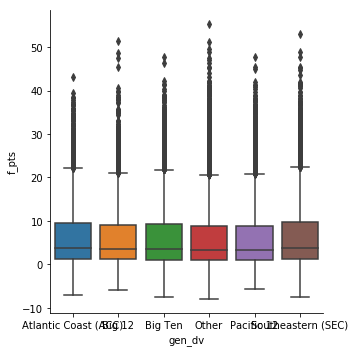

In [210]:
sb.catplot(x='gen_dv', y='f_pts', kind='box', data=df_eda)

#### Explore the underdog feature

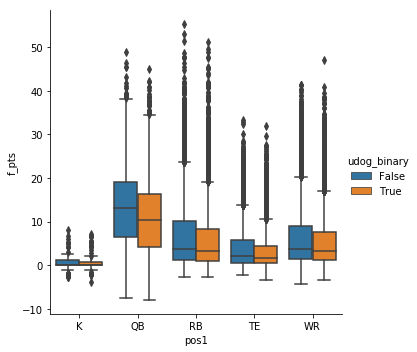

In [213]:
sb.catplot(x='pos1', y='f_pts', hue='udog_binary', kind='box', data=df_eda)

In [214]:
df_eda.groupby(['pos1', 'udog_binary'], as_index=True).agg({'f_pts': ['min', 'max', 'mean', 'median']})

f_pts                             
                       min    max       mean     median
pos1 udog_binary                                       
K    False       -2.800000   8.10   0.489611   0.000000
     True        -3.900000   7.10   0.484279   0.000000
QB   False       -7.440000  48.82  13.065708  13.070000
     True        -7.990000  44.99  10.789780  10.320000
RB   False       -2.800000  55.40   6.609011   3.700000
     True        -2.800000  51.20   5.627840   3.200000
TE   False       -2.200000  33.40   3.753956   2.000000
     True        -3.300000  32.00   3.203514   1.600000
WR   False       -4.342857  41.40   5.865394   3.771429
     True        -3.500000  47.10   5.165432   3.300000

#### Analyze the cumulative stat features

In [94]:
#remove rows where it is NA due to the lag
df_eda_roll = df_eda[~df_eda.loc[:, 'cusum_pa':'recent_tdret'].isna().any(axis=1)]

In [98]:
#career passing versus next week's fantasy points
df_eda_roll.loc[(df_eda_roll['pos1']=='QB') & (df_eda_roll['cusum_pa'] > 100), ['f_pts', 'recent_py']].corr(method='pearson')

,f_pts,recent_py
f_pts,1.000000,0.267971
recent_py,0.267971,1.000000


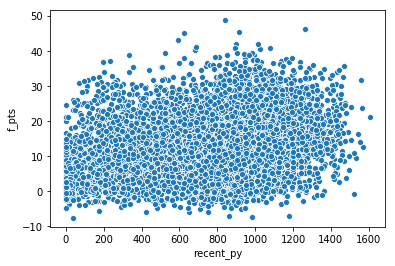

In [97]:
sb.scatterplot(x='recent_py', y='f_pts',
               data=df_eda_roll.loc[(df_eda_roll['pos1']=='QB') & (df_eda_roll['cusum_pa'] > 100), :])

### Game features

In [100]:
df_eda_roll.groupby(['pos1', 'gen_cond']).agg({'f_pts': ['median', 'count']})

f_pts       
                     median  count
pos1 gen_cond                     
QB   fair_cond    12.255000   6350
     indoor_cond  13.430000   2171
     percip_cond  10.720000    831
RB   fair_cond     3.600000  17711
     indoor_cond   3.900000   5800
     percip_cond   3.400000   2273
TE   fair_cond     2.000000  10169
     indoor_cond   1.900000   3491
     percip_cond   1.700000   1267
WR   fair_cond     3.600000  22709
     indoor_cond   3.942857   7839
     percip_cond   3.114286   2877